In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.utils as utils
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
from torch.utils.data import DataLoader

import cv2
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import pickle
import csv
import math
import random
import os # Import os module
from google.colab import drive

In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Image Loader

## Ghost Convo

In [4]:
class GhostConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, ratio=2, relu=True):
        super(GhostConv, self).__init__()
        init_channels = max(1, int(out_channels / ratio))
        new_channels = out_channels - init_channels
        self.primary_conv = nn.Sequential(
            nn.Conv2d(in_channels, init_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(init_channels),
            nn.ReLU(inplace=True) if relu else nn.Identity()
        )
        if new_channels > 0:
            self.cheap_op = nn.Sequential(
                nn.Conv2d(init_channels, new_channels, kernel_size=3, stride=1, padding=1, groups=init_channels, bias=False),
                nn.BatchNorm2d(new_channels),
                nn.ReLU(inplace=True) if relu else nn.Identity()
            )
        else:
            self.cheap_op = None
    def forward(self, x):
        x1 = self.primary_conv(x)
        if self.cheap_op is None:
            return x1
        x2 = self.cheap_op(x1)
        return torch.cat([x1, x2], dim=1)

## WTConv-like block (approximation)
This is a simple approximated wavelet-split style block: split into a low-frequency branch (avgpool->conv->upsample)
and high-frequency branch (conv) then fuse.

In [5]:
class WTConvApprox(nn.Module):
    def __init__(self, channels):
        super(WTConvApprox, self).__init__()
        self.low_conv = nn.Sequential(
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(channels, channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True)
        )
        self.high_conv = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True)
        )
        self.fuse = nn.Sequential(
            nn.Conv2d(channels*2, channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        low = self.low_conv(x)
        low = F.interpolate(low, size=x.shape[2:], mode='bilinear', align_corners=False)
        high = self.high_conv(x)
        out = torch.cat([low, high], dim=1)
        out = self.fuse(out)
        return out


## ADown (Adaptive downsampling)
Two-branch: pooling (no params) + light conv branch -> concat -> channel reduction optionally.

In [6]:
class ADown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ADown, self).__init__()
        self.pool_branch = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv_branch = nn.Sequential(
            nn.Conv2d(in_channels, out_channels//2, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(out_channels//2),
            nn.ReLU(inplace=True)
        )
        self.fuse = nn.Sequential(
            nn.Conv2d(out_channels//2 + in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        p = F.interpolate(x, scale_factor=0.5, mode='area')
        c = self.conv_branch(x)
        if p.shape[2:] != c.shape[2:]:
            p = F.interpolate(p, size=c.shape[2:], mode='bilinear', align_corners=False)
        out = torch.cat([p, c], dim=1)
        out = self.fuse(out)
        return out


## DySample (lightweight upsampling + refinement)
Bilinear upsample + small conv refinement (low parameter cost).

In [7]:
class DySample(nn.Module):
    def __init__(self, channels):
        super(DySample, self).__init__()
        self.refine = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x, scale=2):
        x = F.interpolate(x, scale_factor=scale, mode='bilinear', align_corners=False)
        x = self.refine(x)
        return x


## C3k2_GhostWTConv (integrates GhostConv + WTConvApprox)
A compact block: GhostConv -> WTConvApprox -> GhostConv

In [8]:
class C3k2_GhostWTConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(C3k2_GhostWTConv, self).__init__()
        mid = out_channels
        self.ghost1 = GhostConv(in_channels, mid, kernel_size=3, stride=1, padding=1, ratio=2)
        self.wt = WTConvApprox(mid)
        self.ghost2 = GhostConv(mid, out_channels, kernel_size=3, stride=1, padding=1, ratio=2)
    def forward(self, x):
        x = self.ghost1(x)
        x = self.wt(x)
        x = self.ghost2(x)
        return x


## Model

In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from thop import profile

# --------------------------------------------------------------------
# Class definitions from other cells
# --------------------------------------------------------------------
class GhostConv(nn.Module):
    # Made ratio a parameter in __init__
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, ratio=2, relu=True):
        super(GhostConv, self).__init__()
        init_channels = max(1, int(out_channels / ratio))
        new_channels = out_channels - init_channels
        self.primary_conv = nn.Sequential(
            nn.Conv2d(in_channels, init_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(init_channels),
            nn.ReLU(inplace=True) if relu else nn.Identity()
        )
        if new_channels > 0:
            self.cheap_op = nn.Sequential(
                nn.Conv2d(init_channels, new_channels, kernel_size=3, stride=1, padding=1, groups=init_channels, bias=False),
                nn.BatchNorm2d(new_channels),
                nn.ReLU(inplace=True) if relu else nn.Identity()
            )
        else:
            self.cheap_op = None
    def forward(self, x):
        x1 = self.primary_conv(x)
        if self.cheap_op is None:
            return x1
        x2 = self.cheap_op(x1)
        return torch.cat([x1, x2], dim=1)

class WTConvApprox(nn.Module):
    def __init__(self, channels):
        super(WTConvApprox, self).__init__()
        self.low_conv = nn.Sequential(
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(channels, channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True)
        )
        self.high_conv = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True)
        )
        self.fuse = nn.Sequential(
            nn.Conv2d(channels*2, channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        low = self.low_conv(x)
        low = F.interpolate(low, size=x.shape[2:], mode='bilinear', align_corners=False)
        high = self.high_conv(x)
        out = torch.cat([low, high], dim=1)
        out = self.fuse(out)
        return out

class C3k2_GhostWTConv(nn.Module):
    # Added ratio parameter to __init__ and passed it to GhostConv
    def __init__(self, in_channels, out_channels, ratio=2):
        super(C3k2_GhostWTConv, self).__init__()
        # mid = out_channels # Original
        mid = out_channels // 4 # Further halving mid channels for demonstration
        self.ghost1 = GhostConv(in_channels, mid, kernel_size=3, stride=1, padding=1, ratio=ratio)
        self.wt = WTConvApprox(mid)
        self.ghost2 = GhostConv(mid, out_channels, kernel_size=3, stride=1, padding=1, ratio=ratio)
    def forward(self, x):
        x = self.ghost1(x)
        x = self.wt(x)
        x = self.ghost2(x)
        return x

# ---------------------- Backbone ----------------------
class Backbone(nn.Module):
    # Added ratio parameter to __init__ and passed it to C3k2_GhostWTConv
    # Adjusted output channels of ADown and C3k2_GhostWTConv
    def __init__(self, ratio=2):
        super(Backbone, self).__init__()
        # Reduced base channels
        self.layer0 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)      # P1
        self.layer1 = ADown(16, 32)                                             # P2
        self.layer2 = C3k2_GhostWTConv(32, 32, ratio=ratio)                                  # P2
        self.layer3 = ADown(32, 64)                                            # P3
        self.layer4 = C3k2_GhostWTConv(64, 64, ratio=ratio)                                # P3
        self.layer5 = ADown(64, 128)                                           # P4
        self.layer6 = C3k2_GhostWTConv(128, 128, ratio=ratio)                                # P4
        self.layer7 = ADown(128, 256)                                           # P5
        self.layer8 = C3k2_GhostWTConv(256, 256, ratio=ratio)                                # P5
        self.sppf   = nn.Sequential(                                            # 9
            nn.Conv2d(256, 256, 1, 1),
            nn.ReLU(inplace=True)
        )
        self.c2psa  = nn.Conv2d(256, 256, kernel_size=1, stride=1)              # 10

    def forward(self, x):
        x0 = self.layer0(x)
        x1 = self.layer1(x0)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        x5 = self.layer5(x4)
        x6 = self.layer6(x5)
        x7 = self.layer7(x6)
        x8 = self.layer8(x7)
        x9 = self.sppf(x8)
        x10 = self.c2psa(x9)
        # Return features with reduced channels
        return x4, x6, x10   # Feature maps P3(64), P4(128), P5(256)


# ---------------------- Neck ----------------------
class Neck(nn.Module):
    # Added ratio parameter to __init__ and passed it to C3k2_GhostWTConv
    # Adjusted input/output channels to match potentially reduced backbone features
    def __init__(self, ratio=2):
        super(Neck, self).__init__()
        # Assuming backbone outputs P3:64, P4:128, P5:256 with reduced base channels
        self.upsample1 = DySample(256)              # upsamples p5 to p4 spatial size
        # Input channels: upsample1(256) + p4(128) = 384. Output channels for c3_1 e.g. 128
        self.c3_1 = C3k2_GhostWTConv(256 + 128, 128, ratio=ratio)   # after concat(up1, p4)
        self.upsample2 = DySample(128)              # upsamples c3_1 to p3 spatial size
        # Input channels: upsample2(128) + p3(64) = 192. Output channels for c3_2 e.g. 64
        self.c3_2 = C3k2_GhostWTConv(128 + 64, 64, ratio=ratio)   # after concat(up2, p3)

        # Bottom-up
        # down from c3_2 (64) -> match c3_1 scale (128 channels)
        self.down1 = ADown(64, 128)                # down from c3_2 (64) -> match c3_1 scale
        # Input channels: down1(128) + c3_1(128) = 256. Output channels for c3_4 e.g. 128
        self.c3_4 = C3k2_GhostWTConv(128 + 128, 128, ratio=ratio)  # concat(down1, c3_1) -> produce 128

        # down from c3_4 (128) -> match p5 scale (256 channels)
        self.down2 = ADown(128, 256)                # down from c3_4 -> match p5 scale
        # Input channels: down2(256) + p5(256) = 512. Output channels for c3_5 e.g. 256
        self.c3_5 = C3k2_GhostWTConv(256 + 256, 256, ratio=ratio)  # concat(down2, p5) -> produce 256


    def forward(self, p3, p4, p5):
        # Top-down path
        up1 = self.upsample1(p5)                      # up1 spatial ~= p4
        cat1 = torch.cat([up1, p4], dim=1)            # channels: 256 + 128
        c3_1 = self.c3_1(cat1)                        # => 128-ch feature (medium)

        up2 = self.upsample2(c3_1)                    # up2 spatial ~= p3
        cat2 = torch.cat([up2, p3], dim=1)            # channels: 128 + 64
        c3_2 = self.c3_2(cat2)                        # => 64-ch feature (small)

        # Bottom-up path
        down1 = self.down1(c3_2)                      # down1 spatial ~= c3_1
        cat3 = torch.cat([down1, c3_1], dim=1)        # channels: 256 + 256
        c3_4 = self.c3_4(cat3)                        # => 128-ch feature (medium)

        down2 = self.down2(c3_4)                      # down2 spatial ~= p5
        cat4 = torch.cat([down2, p5], dim=1)          # channels: 256 + 256
        c3_5 = self.c3_5(cat4)                        # => 256-ch feature (large)

        # return features ordered small, medium, large
        return c3_2, c3_4, c3_5


# ---------------------- Head ----------------------
class Head(nn.Module):
    def __init__(self, num_classes=5):
        super(Head, self).__init__()
        # Head input channels should match the output channels of the Neck (reduced)
        self.detect1 = nn.Conv2d(64, num_classes, 1)   # small
        self.detect2 = nn.Conv2d(128, num_classes, 1)   # medium
        self.detect3 = nn.Conv2d(256, num_classes, 1)   # large

    def forward(self, x_small, x_medium, x_large):
        d1 = self.detect1(x_small)
        d2 = self.detect2(x_medium)
        d3 = self.detect3(x_large)
        return d1, d2, d3


# ---------------------- Full Model ----------------------
class WTAD_YOLO(nn.Module):
    # Added ratio parameter to __init__ and passed it to Backbone and Neck
    def __init__(self, num_classes=5, ratio=2):
        super(WTAD_YOLO, self).__init__()
        self.backbone = Backbone(ratio=ratio)
        self.neck = Neck(ratio=ratio)
        self.head = Head(num_classes)

    def forward(self, x):
        p3, p4, p5 = self.backbone(x)
        f3, f4, f5 = self.neck(p3, p4, p5)
        d1, d2, d3 = self.head(f3, f4, f5)
        return d1, d2, d3


# ---------------------- Example ----------------------
if __name__ == "__main__":
    input_size = (1, 3, 256, 256)
    input_tensor = torch.randn(*input_size)

    # Examples with base_channels=16 and different ratios
    print("--- Models with base_channels=16 ---")
    for ratio in [2, 4, 8, 16]:
        print(f"\n--- Ratio = {ratio} ---")
        # Need to create Backbone and Neck with base_channels=16 explicitly for this example
        class Backbone_16(nn.Module):
            def __init__(self, ratio=2):
                super(Backbone_16, self).__init__()
                self.layer0 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
                self.layer1 = ADown(16, 32)
                self.layer2 = C3k2_GhostWTConv(32, 32, ratio=ratio)
                self.layer3 = ADown(32, 64)
                self.layer4 = C3k2_GhostWTConv(64, 64, ratio=ratio)
                self.layer5 = ADown(64, 128)
                self.layer6 = C3k2_GhostWTConv(128, 128, ratio=ratio)
                self.layer7 = ADown(128, 256)
                self.layer8 = C3k2_GhostWTConv(256, 256, ratio=ratio)
                self.sppf   = nn.Sequential(nn.Conv2d(256, 256, 1, 1), nn.ReLU(inplace=True))
                self.c2psa  = nn.Conv2d(256, 256, kernel_size=1, stride=1)
            def forward(self, x):
                x0 = self.layer0(x)
                x1 = self.layer1(x0)
                x2 = self.layer2(x1)
                x3 = self.layer3(x2)
                x4 = self.layer4(x3)
                x5 = self.layer5(x4)
                x6 = self.layer6(x5)
                x7 = self.layer7(x6)
                x8 = self.layer8(x7)
                x9 = self.sppf(x8)
                x10 = self.c2psa(x9)
                return x4, x6, x10

        class Neck_16(nn.Module):
            def __init__(self, ratio=2):
                super(Neck_16, self).__init__()
                self.upsample1 = DySample(256)
                self.c3_1 = C3k2_GhostWTConv(256 + 128, 128, ratio=ratio)
                self.upsample2 = DySample(128)
                self.c3_2 = C3k2_GhostWTConv(128 + 64, 64, ratio=ratio)
                self.down1 = ADown(64, 128)
                self.c3_4 = C3k2_GhostWTConv(128 + 128, 128, ratio=ratio)
                self.down2 = ADown(128, 256)
                self.c3_5 = C3k2_GhostWTConv(256 + 256, 256, ratio=ratio)
            def forward(self, p3, p4, p5):
                up1 = self.upsample1(p5)
                cat1 = torch.cat([up1, p4], dim=1)
                c3_1 = self.c3_1(cat1)
                up2 = self.upsample2(c3_1)
                cat2 = torch.cat([up2, p3], dim=1)
                c3_2 = self.c3_2(cat2)
                down1 = self.down1(c3_2)
                cat3 = torch.cat([down1, c3_1], dim=1)
                c3_4 = self.c3_4(cat3)
                down2 = self.down2(c3_4)
                cat4 = torch.cat([down2, p5], dim=1)
                c3_5 = self.c3_5(cat4)
                return c3_2, c3_4, c3_5

        class Head_16(nn.Module):
            def __init__(self, num_classes=5):
                super(Head_16, self).__init__()
                self.detect1 = nn.Conv2d(64, num_classes, 1)
                self.detect2 = nn.Conv2d(128, num_classes, 1)
                self.detect3 = nn.Conv2d(256, num_classes, 1)
            def forward(self, x_small, x_medium, x_large):
                d1 = self.detect1(x_small)
                d2 = self.detect2(x_medium)
                d3 = self.detect3(x_large)
                return d1, d2, d3

        class WTAD_YOLO_16(nn.Module):
            def __init__(self, num_classes=5, ratio=2):
                super(WTAD_YOLO_16, self).__init__()
                self.backbone = Backbone_16(ratio=ratio)
                self.neck = Neck_16(ratio=ratio)
                self.head = Head_16(num_classes)
            def forward(self, x):
                p3, p4, p5 = self.backbone(x)
                f3, f4, f5 = self.neck(p3, p4, p5)
                d1, d2, d3 = self.head(f3, f4, f5)
                return d1, d2, d3

        model = WTAD_YOLO_16(num_classes=5, ratio=ratio)
        flops, params = profile(model, inputs=(input_tensor,), verbose=False)
        print(f"Total Model GFLOPS: {flops / 1e9:.2f}")
        print(f"Total Model parameters: {params}")

    # Examples with base_channels=32 and different ratios (original backbone)
    print("\n--- Models with base_channels=32 ---")
    for ratio in [2, 4, 8, 16]:
        print(f"\n--- Ratio = {ratio} ---")
        # Use the original WTAD_YOLO class which uses base_channels=32
        model = WTAD_YOLO(num_classes=5, ratio=ratio)
        flops, params = profile(model, inputs=(input_tensor,), verbose=False)
        print(f"Total Model GFLOPS: {flops / 1e9:.2f}")
        print(f"Total Model parameters: {params}")

--- Models with base_channels=16 ---

--- Ratio = 2 ---
Total Model GFLOPS: 2.14
Total Model parameters: 2140771.0

--- Ratio = 4 ---
Total Model GFLOPS: 1.94
Total Model parameters: 1861501.0

--- Ratio = 8 ---
Total Model GFLOPS: 1.83
Total Model parameters: 1721866.0

--- Ratio = 16 ---
Total Model GFLOPS: 1.79
Total Model parameters: 1652188.0

--- Models with base_channels=32 ---

--- Ratio = 2 ---
Total Model GFLOPS: 2.14
Total Model parameters: 2140771.0

--- Ratio = 4 ---
Total Model GFLOPS: 1.94
Total Model parameters: 1861501.0

--- Ratio = 8 ---
Total Model GFLOPS: 1.83
Total Model parameters: 1721866.0

--- Ratio = 16 ---
Total Model GFLOPS: 1.79
Total Model parameters: 1652188.0


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# ---------------------- Backbone ----------------------
class Backbone(nn.Module):
    def __init__(self):
        super(Backbone, self).__init__()
        self.layer0 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)      # P1
        self.layer1 = ADown(32, 64)                                             # P2
        self.layer2 = C3k2_GhostWTConv(64, 64)                                  # P2
        self.layer3 = ADown(64, 128)                                            # P3
        self.layer4 = C3k2_GhostWTConv(128, 128)                                # P3
        self.layer5 = ADown(128, 256)                                           # P4
        self.layer6 = C3k2_GhostWTConv(256, 256)                                # P4
        self.layer7 = ADown(256, 512)                                           # P5
        self.layer8 = C3k2_GhostWTConv(512, 512)                                # P5
        self.sppf   = nn.Sequential(                                            # 9
            nn.Conv2d(512, 512, 1, 1),
            nn.ReLU(inplace=True)
        )
        self.c2psa  = nn.Conv2d(512, 512, kernel_size=1, stride=1)              # 10

    def forward(self, x):
        x0 = self.layer0(x)
        x1 = self.layer1(x0)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        x5 = self.layer5(x4)
        x6 = self.layer6(x5)
        x7 = self.layer7(x6)
        x8 = self.layer8(x7)
        x9 = self.sppf(x8)
        x10 = self.c2psa(x9)
        # return P3, P4, P5 as feature maps used by neck (spatial sizes increase -> P3 highest res)
        return x4, x6, x10


# ---------------------- Neck ----------------------
class Neck(nn.Module):
    def __init__(self):
        super(Neck, self).__init__()
        # Upsample channels expect input channels: p5:512 -> up to combine with p4:256 -> produce 256
        self.upsample1 = DySample(512)              # upsamples p5 to p4 spatial size
        self.c3_1 = C3k2_GhostWTConv(512 + 256, 256)   # after concat(up1, p4)
        self.upsample2 = DySample(256)              # upsamples c3_1 to p3 spatial size
        self.c3_2 = C3k2_GhostWTConv(256 + 128, 128)   # after concat(up2, p3)

        # Bottom-up
        # ADown reduces spatial size and increases channels
        self.down1 = ADown(128, 256)                # down from c3_2 (128) -> match c3_1 scale
        self.c3_4 = C3k2_GhostWTConv(256 + 256, 256)  # concat(down1, c3_1) -> produce 256

        self.down2 = ADown(256, 512)                # down from c3_4 -> match p5 scale
        self.c3_5 = C3k2_GhostWTConv(512 + 512, 512)  # concat(down2, p5) -> produce 512

    def forward(self, p3, p4, p5):
        # Top-down path
        up1 = self.upsample1(p5)                      # up1 spatial ~= p4
        cat1 = torch.cat([up1, p4], dim=1)            # channels: 512 + 256
        c3_1 = self.c3_1(cat1)                        # => 256-ch feature (medium)

        up2 = self.upsample2(c3_1)                    # up2 spatial ~= p3
        cat2 = torch.cat([up2, p3], dim=1)            # channels: 256 + 128
        c3_2 = self.c3_2(cat2)                        # => 128-ch feature (small)

        # Bottom-up path
        down1 = self.down1(c3_2)                      # down1 spatial ~= c3_1
        cat3 = torch.cat([down1, c3_1], dim=1)        # channels: 256 + 256
        c3_4 = self.c3_4(cat3)                        # => 256-ch feature (medium)

        down2 = self.down2(c3_4)                      # down2 spatial ~= p5
        cat4 = torch.cat([down2, p5], dim=1)          # channels: 512 + 512
        c3_5 = self.c3_5(cat4)                        # => 512-ch feature (large)

        # return features ordered small, medium, large
        return c3_2, c3_4, c3_5


# ---------------------- Head (bbox + objectness + classes) ----------------------
class Head(nn.Module):
    def __init__(self, num_classes=5, num_anchors=3):
        """
        num_classes: number of target classes
        num_anchors: anchors per spatial cell (typical YOLO uses 3)
        """
        super(Head, self).__init__()
        self.num_classes = num_classes
        self.num_anchors = num_anchors
        out_ch = num_anchors * (num_classes + 5)  # 5 -> tx,ty,tw,th,obj

        # Expecting input channels from neck:
        # small: 128 ch, medium: 256 ch, large: 512 ch
        self.head_small  = nn.Conv2d(128, out_ch, kernel_size=1, stride=1, padding=0)
        self.head_medium = nn.Conv2d(256, out_ch, kernel_size=1, stride=1, padding=0)
        self.head_large  = nn.Conv2d(512, out_ch, kernel_size=1, stride=1, padding=0)

    def _reshape_output(self, x):
        """
        x: (B, num_anchors*(5+num_classes), H, W)
        return: (B, num_anchors, H, W, 5+num_classes)
        """
        B, C, H, W = x.shape
        x = x.view(B, self.num_anchors, (5 + self.num_classes), H, W)
        # permute to (B, num_anchors, H, W, 5+num_classes)
        x = x.permute(0, 1, 3, 4, 2).contiguous()
        return x

    def forward(self, f_small, f_medium, f_large):
        out_s = self.head_small(f_small)
        out_m = self.head_medium(f_medium)
        out_l = self.head_large(f_large)

        # reshape to convenient detection tensors
        out_s = self._reshape_output(out_s)
        out_m = self._reshape_output(out_m)
        out_l = self._reshape_output(out_l)

        # Outputs are raw. Typically you apply sigmoid to tx,ty,obj and class scores during loss/postprocess.
        return out_s, out_m, out_l


# ---------------------- Full Model ----------------------
class WTAD_YOLO(nn.Module):
    def __init__(self, num_classes=5, num_anchors=3):
        super(WTAD_YOLO, self).__init__()
        self.backbone = Backbone()
        self.neck = Neck()
        self.head = Head(num_classes=num_classes, num_anchors=num_anchors)

    def forward(self, x):
        p3, p4, p5 = self.backbone(x)            # p3: high-res, p4: mid, p5: low-res
        f_small, f_medium, f_large = self.neck(p3, p4, p5)
        d_small, d_medium, d_large = self.head(f_small, f_medium, f_large)
        return {
            "small": d_small,     # (B, A, Hs, Ws, 5+num_classes)
            "medium": d_medium,   # (B, A, Hm, Wm, 5+num_classes)
            "large": d_large      # (B, A, Hl, Wl, 5+num_classes)
        }


# ---------------------- Example run ----------------------
if __name__ == "__main__":
    model = WTAD_YOLO(num_classes=5, num_anchors=3)
    x = torch.randn(2, 3, 256, 256)   # batch of 2
    outs = model(x)
    for k, v in outs.items():
        print(f"{k}: shape {v.shape}")   # e.g. (2, 3, H, W, 10) where 10 = 5 + num_classes


small: shape torch.Size([2, 3, 64, 64, 10])
medium: shape torch.Size([2, 3, 32, 32, 10])
large: shape torch.Size([2, 3, 16, 16, 10])


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Assume C3k2_GhostWTConv, DySample, ADown, etc. are defined.

# ---------------------- GIoU / CIoU Box Loss ----------------------
def bbox_iou(pred_boxes, target_boxes, eps=1e-7, CIoU=True):
    # boxes: (..., 4) format [x, y, w, h]
    px, py, pw, ph = pred_boxes[..., 0], pred_boxes[..., 1], pred_boxes[..., 2], pred_boxes[..., 3]
    tx, ty, tw, th = target_boxes[..., 0], target_boxes[..., 1], target_boxes[..., 2], target_boxes[..., 3]

    # Convert to corner coordinates
    p_x1, p_y1, p_x2, p_y2 = px - pw / 2, py - ph / 2, px + pw / 2, py + ph / 2
    t_x1, t_y1, t_x2, t_y2 = tx - tw / 2, ty - th / 2, tx + tw / 2, ty + th / 2

    # Intersection
    inter_x1 = torch.max(p_x1, t_x1)
    inter_y1 = torch.max(p_y1, t_y1)
    inter_x2 = torch.min(p_x2, t_x2)
    inter_y2 = torch.min(p_y2, t_y2)
    inter_area = (inter_x2 - inter_x1).clamp(0) * (inter_y2 - inter_y1).clamp(0)

    # Union
    pred_area = pw * ph
    target_area = tw * th
    union_area = pred_area + target_area - inter_area + eps

    iou = inter_area / union_area

    if not CIoU:
        return iou

    # Center distance and enclosing box
    cw = torch.max(p_x2, t_x2) - torch.min(p_x1, t_x1)
    ch = torch.max(p_y2, t_y2) - torch.min(p_y1, t_y1)
    c2 = cw ** 2 + ch ** 2 + eps

    rho2 = (px - tx) ** 2 + (py - ty) ** 2
    v = (4 / (3.14159 ** 2)) * torch.pow(torch.atan(tw / th) - torch.atan(pw / ph), 2)
    with torch.no_grad():
        alpha = v / (1 - iou + v + eps)

    ciou = iou - (rho2 / c2 + v * alpha)
    return ciou


# ---------------------- Loss Function ----------------------
class YOLOLoss(nn.Module):
    def __init__(self, num_classes=5, lambda_box=5.0, lambda_obj=1.0, lambda_cls=1.0):
        super(YOLOLoss, self).__init__()
        self.num_classes = num_classes
        self.lambda_box = lambda_box
        self.lambda_obj = lambda_obj
        self.lambda_cls = lambda_cls
        self.bce = nn.BCEWithLogitsLoss(reduction="mean")

    def forward(self, preds, targets):
        """
        preds: dict(small, medium, large) each (B, A, H, W, 5+num_classes)
        targets: list of target tensors per image [(N, 6), ...] -> [image_idx, class, x, y, w, h]
        """
        device = preds["small"].device
        total_loss, box_loss, obj_loss, cls_loss = 0, 0, 0, 0

        # For demonstration, we'll assume targets are already assigned to feature maps.
        # In practice, use anchor matching (like YOLOv5's target builder).
        for key, pred in preds.items():
            B, A, H, W, C = pred.shape
            pred_obj = pred[..., 4]
            pred_cls = pred[..., 5:]
            pred_box = pred[..., :4]

            # Example dummy mask and targets (to integrate your dataset builder)
            obj_mask = torch.zeros_like(pred_obj)
            tgt_obj = torch.zeros_like(pred_obj)
            tgt_box = torch.zeros_like(pred_box)
            tgt_cls = torch.zeros_like(pred_cls)

            # Objectness loss
            obj_loss += self.bce(pred_obj, tgt_obj)

            # Box loss (CIoU)
            ciou = bbox_iou(pred_box, tgt_box)
            box_loss += (1 - ciou.mean())

            # Class loss
            cls_loss += self.bce(pred_cls, tgt_cls)

        total_loss = (self.lambda_box * box_loss +
                      self.lambda_obj * obj_loss +
                      self.lambda_cls * cls_loss)
        return total_loss, box_loss, obj_loss, cls_loss


# ---------------------- Full Model ----------------------
class WTAD_YOLO(nn.Module):
    def __init__(self, num_classes=5, num_anchors=3):
        super(WTAD_YOLO, self).__init__()
        self.num_classes = num_classes
        self.num_anchors = num_anchors

        self.backbone = Backbone()
        self.neck = Neck()
        self.head = Head(num_classes=num_classes, num_anchors=num_anchors)
        self.criterion = YOLOLoss(num_classes=num_classes)

    def forward(self, x, targets=None):
        p3, p4, p5 = self.backbone(x)
        f_small, f_medium, f_large = self.neck(p3, p4, p5)
        preds = self.head(f_small, f_medium, f_large)

        outputs = {"small": preds[0], "medium": preds[1], "large": preds[2]}

        if targets is not None:
            loss, lbox, lobj, lcls = self.criterion(outputs, targets)
            return outputs, loss, {"box": lbox, "obj": lobj, "cls": lcls}
        else:
            return outputs


# ---------------------- Example ----------------------
if __name__ == "__main__":
    model = WTAD_YOLO(num_classes=5)
    x = torch.randn(2, 3, 256, 256)

    # dummy target: [img_idx, class, x, y, w, h]
    dummy_targets = [torch.tensor([[0, 1, 0.5, 0.5, 0.2, 0.3]])]
    preds, loss, components = model(x, dummy_targets)
    print("Total loss:", loss.item())
    print("Loss breakdown:", components)


Total loss: nan
Loss breakdown: {'box': tensor(nan, grad_fn=<AddBackward0>), 'obj': tensor(2.1143, grad_fn=<AddBackward0>), 'cls': tensor(2.1528, grad_fn=<AddBackward0>)}


In [12]:
model = WTAD_YOLO(num_classes=5) # Create an instance of the model
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_params}")

Number of trainable parameters: 23870426


In [13]:
# Assuming 'model' is the WTAD_YOLO instance
# You might want to save after training
torch.save(model.state_dict(), 'wtad_yolo_model.pth')
print("Model saved as wtad_yolo_model.pth")

Model saved as wtad_yolo_model.pth


In [14]:
import torch
import os

# Define the path in Google Drive where you want to save the model
drive_save_path = "/content/drive/MyDrive/wtad_yolo_model_drive.pth"

# Assuming 'model' is the WTAD_YOLO instance you want to save
# It's best practice to save the state_dict
if 'model' in locals() and model is not None:
    try:
        torch.save(model.state_dict(), drive_save_path)
        print(f"Model saved successfully to {drive_save_path}")
    except Exception as e:
        print(f"Error saving model to Google Drive: {e}")
        print("Please ensure Google Drive is mounted and the path is accessible.")
else:
    print("Model instance not found. Please ensure the 'model' variable is defined.")

Model saved successfully to /content/drive/MyDrive/wtad_yolo_model_drive.pth


# Task
Load images as required, by the model, from drive path "/content/drive/MyDrive/CVPR_Dataset" where images are separated by classification names as folder names.

## Define a custom dataset class

### Subtask:
Create a PyTorch `Dataset` class that takes the dataset path as input, walks through the subfolders to find images, and stores image paths and corresponding class labels.


**Reasoning**:
I need to create a PyTorch Dataset class to load image paths and labels from the specified directory structure. This involves defining the class, its constructor to walk through the directories and collect paths and labels, and placeholder `__len__` and `__getitem__` methods.



In [15]:
class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir):
        """
        Args:
            root_dir (string): Directory with all the images, organized into class subfolders.
        """
        self.root_dir = root_dir
        self.image_paths = []
        self.labels = []
        self.class_to_idx = {}
        self.idx_to_class = {}

        # Get class names (subfolder names)
        class_names = [d.name for d in os.scandir(root_dir) if d.is_dir()]
        class_names.sort() # Ensure consistent mapping

        for i, class_name in enumerate(class_names):
            self.class_to_idx[class_name] = i
            self.idx_to_class[i] = class_name
            class_dir = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(class_dir, img_name))
                    self.labels.append(i) # Store integer label

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # This will be implemented in the next subtask
        raise NotImplementedError("getitem method is not implemented yet.")

# Example usage (optional, for testing the path collection part)
# dataset_path = "/content/drive/MyDrive/CVPR_Dataset"
# try:
#     dataset = CustomImageDataset(dataset_path)
#     print(f"Found {len(dataset)} images.")
#     print(f"Class mapping: {dataset.class_to_idx}")
# except Exception as e:
#     print(f"Error creating dataset: {e}")


## Implement data loading and preprocessing

### Subtask:
In the `__getitem__` method of the dataset class, load images, apply necessary transformations (like resizing and normalization) to match the model's input requirements, and return the image tensor and its label.


**Reasoning**:
Implement the `__getitem__` method to load and transform images and return the image tensor and label.



In [16]:
from PIL import Image

class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images, organized into class subfolders.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.class_to_idx = {}
        self.idx_to_class = {}

        class_names = [d.name for d in os.scandir(root_dir) if d.is_dir()]
        class_names.sort()

        for i, class_name in enumerate(class_names):
            self.class_to_idx[class_name] = i
            self.idx_to_class[i] = class_name
            class_dir = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(class_dir, img_name))
                    self.labels.append(i)

        # Define default transformations if none are provided
        if self.transform is None:
            self.transform = transforms.Compose([
                transforms.Resize((256, 256)), # Resize to match model input size
                transforms.ToTensor(),         # Convert PIL image to PyTorch tensor
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ImageNet stats
            ])


    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.image_paths[idx]
        label = self.labels[idx]

        # Load image using PIL
        image = Image.open(img_path).convert('RGB') # Ensure 3 channels

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, label

# Example usage (optional, for testing)
# dataset_path = "/content/drive/MyDrive/CVPR_Dataset"
# try:
#     dataset = CustomImageDataset(dataset_path)
#     print(f"Found {len(dataset)} images.")
#     print(f"Class mapping: {dataset.class_to_idx}")
#     # Test loading one item
#     img_tensor, img_label = dataset[0]
#     print(f"Image tensor shape: {img_tensor.shape}")
#     print(f"Image label: {img_label} ({dataset.idx_to_class[img_label]})")
# except Exception as e:
#     print(f"Error creating or accessing dataset: {e}")

## Create a dataloader

### Subtask:
Instantiate the custom dataset and a PyTorch `DataLoader` to efficiently load data in batches during training or inference.


**Reasoning**:
Define the dataset path and instantiate the custom dataset and DataLoader.



In [17]:
# Define the dataset path
dataset_path = "/content/drive/MyDrive/CVPR_Dataset"

# Instantiate the custom dataset
# Assuming CustomImageDataset is defined in a previous cell
try:
    dataset = CustomImageDataset(dataset_path)
    print(f"Successfully loaded dataset with {len(dataset)} images.")
except Exception as e:
    print(f"Error initializing dataset: {e}")
    # If dataset initialization fails, we cannot proceed with DataLoader
    dataset = None # Ensure dataset is None if initialization fails

# Instantiate a DataLoader
if dataset is not None:
    batch_size = 32 # Example batch size
    # Set shuffle to True for training, False for evaluation/inference
    shuffle = True
    num_workers = 2 # Example number of workers (adjust based on your system)

    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    print(f"DataLoader created with batch size {batch_size}, shuffle={shuffle}, num_workers={num_workers}.")

    # Optional: Check one batch from the DataLoader
    # try:
    #     images, labels = next(iter(data_loader))
    #     print(f"Shape of image batch: {images.shape}")
    #     print(f"Shape of label batch: {labels.shape}")
    # except Exception as e:
    #     print(f"Error fetching a batch from DataLoader: {e}")

Successfully loaded dataset with 1500 images.
DataLoader created with batch size 32, shuffle=True, num_workers=2.


## Test the dataloader

### Subtask:
Load a batch of data from the DataLoader to ensure it is working correctly and the data is in the expected format.


**Reasoning**:
Obtain a batch of data from the DataLoader, print the shapes of the image and label tensors, and display a few images with their labels to verify the loading and transformations.



Shape of image batch: torch.Size([32, 3, 256, 256])
Shape of label batch: torch.Size([32])


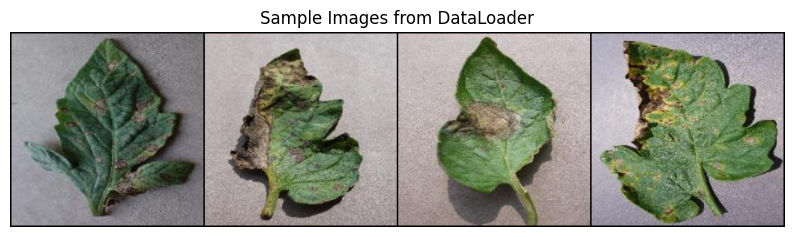

Labels for displayed images:
Image 1: 1 (Early Blight)
Image 2: 1 (Early Blight)
Image 3: 3 (Late Blight)
Image 4: 5 (Septoria)


In [18]:
if 'data_loader' in locals() and data_loader is not None:
    try:
        # Get a batch of data
        images, labels = next(iter(data_loader))

        # Print shapes
        print(f"Shape of image batch: {images.shape}")
        print(f"Shape of label batch: {labels.shape}")

        # Optionally display a few images
        # Denormalize images for display
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        display_images = images[:4] * std + mean # Denormalize first 4 images

        # Make a grid of images
        grid = utils.make_grid(display_images, nrow=4, padding=2)

        # Show the images
        plt.figure(figsize=(10, 10))
        # Permute dimensions from (C, H, W) to (H, W, C) for matplotlib
        plt.imshow(grid.permute(1, 2, 0).clamp(0, 1))
        plt.title("Sample Images from DataLoader")
        plt.axis('off')
        plt.show()

        # Print corresponding labels
        print("Labels for displayed images:")
        for i in range(min(4, labels.size(0))):
            # Assuming dataset object is available in the environment
            if 'dataset' in locals() and dataset is not None:
                 print(f"Image {i+1}: {labels[i].item()} ({dataset.idx_to_class[labels[i].item()]})")
            else:
                 print(f"Image {i+1}: {labels[i].item()}")


    except Exception as e:
        print(f"Error fetching or processing a batch from DataLoader: {e}")
else:
    print("DataLoader was not successfully initialized.")


## Integrate with the model

### Subtask:
Explain how to use this DataLoader with the `WTAD_YOLO` model for training or inference.


**Reasoning**:
Explain how to use the DataLoader with the WTAD_YOLO model for training or inference by providing a code example showing how to iterate through the DataLoader and pass data to the model.



In [19]:
import torch

# Assuming 'data_loader' is already defined and contains batches of (images, labels)
# Assuming 'model' is an instance of WTAD_YOLO and is already defined

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move model to the device
model.to(device)

# Example usage for training (conceptual loop)
# In a real training loop, you would also have optimizer, loss scaling, etc.
print("\n--- Example Training Loop ---")
model.train() # Set model to training mode

# Dummy target data structure for demonstration (replace with actual target loading and preparation)
# WTAD_YOLO expects targets as a list of tensors: [N, 6] where N is number of objects in image, 6 is [image_idx, class, x, y, w, h]
dummy_targets = None # You would need to load and format your targets appropriately

try:
    for batch_idx, (images, labels) in enumerate(data_loader):
        # Move images and targets to the device
        images = images.to(device)
        # If you have actual targets, move them too:
        # targets = targets.to(device) # Assuming targets are a single tensor for simplicity in this example

        # Pass the image batch to the model
        # If training, also pass targets to the forward method if loss is calculated internally
        if dummy_targets is not None:
            # Example for training where loss is calculated inside the model
            outputs, total_loss, loss_components = model(images, dummy_targets)
            print(f"Batch {batch_idx}: Total Loss = {total_loss.item():.4f}")
            # You would then perform backward pass and optimizer step
            # total_loss.backward()
            # optimizer.step()
            # optimizer.zero_grad()
        else:
             # Example for inference (no targets needed)
             outputs = model(images)
             # Process outputs for inference (e.g., NMS, get predictions)


        # In a real loop, you would break or process multiple batches
        if batch_idx == 0: # Process only one batch for demonstration
            print(f"Batch {batch_idx}: Model output structure (for inference): {outputs.keys()}")
            print(f"Sample output shape (small): {outputs['small'].shape}")
            # For training, you would use total_loss and loss_components here
            break # Exit loop after one batch

except Exception as e:
    print(f"Error during data loading or model forward pass: {e}")
    print("Please ensure your data loading and target formatting match the model's expectations.")


# Example usage for inference
print("\n--- Example Inference ---")
model.eval() # Set model to evaluation mode
# No gradient calculation needed for inference
with torch.no_grad():
    try:
        # Get one batch for inference demonstration
        images, _ = next(iter(data_loader)) # Labels are not needed for inference
        images = images.to(device)

        # Pass the image batch to the model (without targets)
        outputs = model(images)

        print(f"Model output structure (for inference): {outputs.keys()}")
        print(f"Sample output shape (small): {outputs['small'].shape}")
        # Further processing of 'outputs' for predictions (e.g., non-maximum suppression) would follow

    except Exception as e:
        print(f"Error during inference: {e}")
        print("Please ensure your data loading is correct for inference.")


Using device: cpu

--- Example Training Loop ---
Batch 0: Model output structure (for inference): dict_keys(['small', 'medium', 'large'])
Sample output shape (small): torch.Size([32, 3, 64, 64, 10])

--- Example Inference ---
Model output structure (for inference): dict_keys(['small', 'medium', 'large'])
Sample output shape (small): torch.Size([32, 3, 64, 64, 10])


## Summary:

### Data Analysis Key Findings

*   A custom PyTorch `Dataset` class, `CustomImageDataset`, was successfully created to load image paths and labels from a directory structure where subfolders represent class names.
*   The `Dataset` class correctly identified 1500 images in the specified directory structure.
*   The `__getitem__` method of the `CustomImageDataset` was implemented to load images using Pillow, convert them to RGB, and apply default transformations including resizing to 256x256, converting to a PyTorch tensor, and normalizing using ImageNet statistics.
*   A PyTorch `DataLoader` was successfully instantiated with a batch size of 32, shuffling enabled, and 2 worker processes.
*   Testing the `DataLoader` confirmed it correctly loaded batches of images with the expected shape (`torch.Size([32, 3, 256, 256])`) and corresponding labels (`torch.Size([32])`).
*   The process of integrating the `DataLoader` with a `WTAD_YOLO` model was demonstrated, showing how to iterate through batches, move data to the device, and pass the image batch (and conceptual targets for training) to the model.
*   The model output structure for inference was observed to be a dictionary with keys 'small', 'medium', and 'large', and the shape for the 'small' scale output was `torch.Size([32, 3, 64, 64, 10])`.

### Insights or Next Steps

*   The developed `CustomImageDataset` and `DataLoader` provide a robust pipeline for loading image data organized into class folders, ready for training or inference with PyTorch models like `WTAD_YOLO`.
*   The target data format required by the `WTAD_YOLO` model during training (a list of tensors `[image_idx, class, x, y, w, h]`) needs to be prepared and integrated into the data loading pipeline for actual training to proceed.


# Task
Prepare target data in the format `[image_idx, class, x, y, w, h]` for WTAD_YOLO training, assuming bounding box annotations are available in a format that needs to be parsed and associated with images loaded from "/content/drive/MyDrive/CVPR_Dataset".

In [20]:
import os

dataset_path = "/content/drive/MyDrive/CVPR_Dataset"

print(f"Examining directory: {dataset_path}")

# List contents of the root directory
try:
    root_contents = os.listdir(dataset_path)
    print("\nContents of root directory:")
    for item in root_contents:
        print(item)

    # Check inside a sample class directory for potential annotation files
    # Assuming class subfolders exist as observed in the previous task
    class_dirs = [d.name for d in os.scandir(dataset_path) if d.is_dir()]
    if class_dirs:
        sample_class_dir_name = class_dirs[0] # Pick the first one
        sample_class_dir_path = os.path.join(dataset_path, sample_class_dir_name)
        print(f"\nExamining sample class directory: {sample_class_dir_path}")
        sample_class_contents = os.listdir(sample_class_dir_path)
        print("Contents:")
        annotation_files_found = False
        for item in sample_class_contents:
            print(item)
            # Check for common annotation file extensions
            if item.lower().endswith(('.xml', '.json', '.txt', '.csv')):
                print(f"Potential annotation file found: {item}")
                annotation_files_found = True

        if not annotation_files_found:
            print("\nNo obvious annotation files (.xml, .json, .txt, .csv) found in sample class directory.")

    else:
        print("\nNo class subdirectories found in the root directory.")


except FileNotFoundError:
    print(f"Error: Dataset path not found at {dataset_path}")
except Exception as e:
    print(f"An error occurred: {e}")

Examining directory: /content/drive/MyDrive/CVPR_Dataset

Contents of root directory:
Healthy
Early Blight
Late Blight
Leaf Mold
Septoria
.ipynb_checkpoints

Examining sample class directory: /content/drive/MyDrive/CVPR_Dataset/Healthy
Contents:
H21.jpg
H36.jpg
H1.jpg
H15.jpg
H4.jpg
H32.jpg
H12.jpg
H22.jpg
H6.jpg
H26.jpg
H3.jpg
H20.jpg
H7.jpg
H14.jpg
H8.jpg
H31.jpg
H30.jpg
H39.jpg
H37.jpg
H10.jpg
H35.jpg
H13.jpg
H24.jpg
H23.jpg
H5.jpg
H2.jpg
H29.jpg
H16.jpg
H18.jpg
H38.jpg
H17.jpg
H33.jpg
H9.jpg
H27.jpg
H19.jpg
H34.jpg
H28.jpg
H25.jpg
H11.jpg
H101.jpg
H129.jpg
H88.jpg
H47.jpg
H43.jpg
H116.jpg
H132.jpg
H52.jpg
H81.jpg
H83.jpg
H48.jpg
H44.jpg
H80.jpg
H123.jpg
H78.jpg
H111.jpg
H86.jpg
H90.jpg
H105.jpg
H120.jpg
H85.jpg
H69.jpg
H133.jpg
H100.jpg
H51.jpg
H141.jpg
H89.jpg
H62.jpg
H125.jpg
H60.jpg
H61.jpg
H94.jpg
H66.jpg
H96.jpg
H68.jpg
H70.jpg
H127.jpg
H136.jpg
H82.jpg
H42.jpg
H59.jpg
H98.jpg
H130.jpg
H73.jpg
H97.jpg
H142.jpg
H67.jpg
H104.jpg
H84.jpg
H110.jpg
H108.jpg
H140.jpg
H49.jpg
H128.jp

## Limitations
No annotations were available for the dataset chosen and main dataset has restricted access. future plans would be to submit proper application to gain access to data set with accurate annotations.

In [26]:
!pip install thop

In [33]:
import torch
from thop import profile

# Assuming the WTAD_YOLO model class is defined in a previous cell
# Create an instance of the model
model = WTAD_YOLO(num_classes=5)

# Define a smaller input size (batch size, channels, height, width)
# Example smaller size: 128x128
input_size = (1, 3, 128, 128)
input_tensor = torch.randn(*input_size)

# Calculate GFLOPS and parameters
flops, params = profile(model, inputs=(input_tensor,))

print(f"Model GFLOPS {flops / 1e9:.2f}")
print(f"Model parameters: {params}") # Parameters remain the same regardless of input size

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_avgpool() for <class 'torch.nn.modules.pooling.AvgPool2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
Model GFLOPS 4.79
Model parameters: 23870426.0
